In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely import wkt
import contextily as ctx
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from math import radians, cos, sin, asin, sqrt
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib.patches import Patch
from sklearn.metrics import pairwise_distances
from scipy.stats import pearsonr
import statsmodels.api as sm

/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Flevoland

### Nitrate data

In [125]:
# Select province to work with
province = "flevoland"

In [126]:
# 1. load data
nitrate_path = f"/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/data/raw/well_chem_data/{province}_well_chem_combined.csv"
nitrate_df = pd.read_csv(nitrate_path)
len(nitrate_df)

2311

In [127]:
# 2. standardize date
nitrate_df['Date'] = pd.to_datetime(nitrate_df['Date'], errors='coerce', utc=True)
len(nitrate_df)

2311

In [128]:
# Remove Nan, Select year after 2000, Choose filters
nitrate_df['year'] = nitrate_df['Date'].dt.year

nitrate_filtered_df = nitrate_df[
    (nitrate_df['Nitrate'].notna()) &
    (nitrate_df['year'] >= 2000) &
    (nitrate_df['Filter'].isin([1, 2, 3]))
]
len(nitrate_filtered_df)

542

In [129]:
# Number of unique wells
nitrate_filtered_df['Well_ID'].nunique()

99

### Depth data

In [80]:
# 1. load data
depth_path = f"/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/data/raw/well_depth_data/{province}_well_depth_combined.csv"
depth_df = pd.read_csv(depth_path)
len(depth_df)

30291661

In [81]:
depth_df['Date'] = pd.to_datetime(depth_df['Date'], errors='coerce', utc=True)
len(depth_df)

30291661

In [84]:
# Select year after 2000, Choose filters
depth_df['year'] = depth_df['Date'].dt.year

depth_filtered_df = depth_df[
    (depth_df['year'] >= 2000) &
    (depth_df['Filter'].isin([0, 1, 2, 3]))
]
len(depth_filtered_df)

28047080

In [85]:
# Number of unique wells
depth_filtered_df['Well_ID'].nunique()

1129

### Comparison

In [86]:
common_ids = set(depth_filtered_df['Well_ID']) & set(nitrate_filtered_df['Well_ID'])
df1_common = depth_filtered_df[depth_filtered_df['Well_ID'].isin(common_ids)]
df2_common = nitrate_filtered_df[nitrate_filtered_df['Well_ID'].isin(common_ids)]
print(len(list(common_ids)))

87


# Utrecht

In [152]:
# Select province to work with
province = "utrecht"

Filter Nitrate dataset:

- Standardize date
- Year after 2000
- Remove Nan in Nitrate
- Filter 1, 2, 3

In [153]:
# 1. load data
nitrate_path = f"/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/data/raw/well_chem_data/{province}_well_chem_combined.csv"
nitrate_df = pd.read_csv(nitrate_path)
len(nitrate_df)

1697

In [154]:
# 2. standardize date
nitrate_df['Date'] = pd.to_datetime(nitrate_df['Date'], errors='coerce', utc=True)
len(nitrate_df)

1697

In [157]:
# Remove Nan, Select year after 2000, Choose filters
nitrate_df['year'] = nitrate_df['Date'].dt.year

nitrate_filtered_df = nitrate_df[
    (nitrate_df['Nitrate'].notna()) &
    (nitrate_df['year'] >= 2000) &
    (nitrate_df['Filter'].isin([1, 2, 3]))
]
len(nitrate_filtered_df)

903

In [124]:
# Number of unique wells
nitrate_filtered_df['Well_ID'].nunique()

90

Filter Depth dataset:

- Standardize date
- Year after 2000
- Filter 1, 2, 3

In [94]:
# 1. load data
depth_path = f"/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/data/raw/well_depth_data/{province}_well_depth_combined.csv"
depth_df = pd.read_csv(depth_path)
len(depth_df)

30200376

In [95]:
depth_df['Date'] = pd.to_datetime(depth_df['Date'], errors='coerce', utc=True)
len(depth_df)

30200376

In [96]:
# Select year after 2000, Choose filters
depth_df['year'] = depth_df['Date'].dt.year

depth_filtered_df = depth_df[
    (depth_df['year'] >= 2000) &
    (depth_df['Filter'].isin([0, 1, 2, 3]))
]
len(depth_filtered_df)

29791968

In [98]:
depth_filtered_df = depth_filtered_df.drop_duplicates().reset_index(drop=True)
len(depth_filtered_df)

28075717

In [97]:
# Number of unique wells
depth_filtered_df['Well_ID'].nunique()

1077

Compare two datasets in terms of Well IDs

In [73]:
common_ids = set(depth_filtered_df['Well_ID']) & set(nitrate_filtered_df['Well_ID'])
df1_common = depth_filtered_df[depth_filtered_df['Well_ID'].isin(common_ids)]
df2_common = nitrate_filtered_df[nitrate_filtered_df['Well_ID'].isin(common_ids)]
print(len(list(common_ids)))

32


In [40]:
# Check year coverage for each common well
for well in common_ids:
    nitrate_years = set(nitrate_filtered_df[nitrate_filtered_df['Well_ID'] == well]['year'].dropna())
    depth_years = set(depth_filtered_df[depth_filtered_df['Well_ID'] == well]['year'].dropna())

    missing_years = nitrate_years - depth_years

    if missing_years:
        print(f"Well {well}: years in nitrate but missing in depth -> {sorted(missing_years)}")
    else:
        print(f"Well {well}: all nitrate years are covered in depth")

Well GMW000000009448: years in nitrate but missing in depth -> [2011]
Well GMW000000025991: all nitrate years are covered in depth
Well GMW000000026002: all nitrate years are covered in depth
Well GMW000000042630: all nitrate years are covered in depth
Well GMW000000009442: years in nitrate but missing in depth -> [2011]
Well GMW000000023914: all nitrate years are covered in depth
Well GMW000000004104: all nitrate years are covered in depth
Well GMW000000024012: years in nitrate but missing in depth -> [2008]
Well GMW000000009411: years in nitrate but missing in depth -> [2011]
Well GMW000000023998: all nitrate years are covered in depth
Well GMW000000023897: years in nitrate but missing in depth -> [2008, 2010, 2012, 2015, 2018, 2021]
Well GMW000000003998: years in nitrate but missing in depth -> [2008, 2010, 2012, 2015, 2018]
Well GMW000000004007: all nitrate years are covered in depth
Well GMW000000023856: all nitrate years are covered in depth
Well GMW000000023977: years in nitrate

### Filter 3, missing values

In [131]:
depth_filter_3_path = "/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/data/clean/well_depth_data/utrecht_well_depth_combined_3.csv"
depth_filter_3_df = pd.read_csv(depth_filter_3_path)

In [134]:
print(len(depth_filter_3_df))
depth_filter_3_df.isna().sum()

466230


Well_ID            0
BRO-ID             0
Filter             0
Date               0
Depth             12
geometry           0
Ground Level     735
Bottom Screen      0
Top Screen         0
Year               0
dtype: int64

In [137]:
missing_depth_rows_3 = depth_filter_3_df[depth_filter_3_df['Depth'].isna()]
print(missing_depth_rows_3)

                Well_ID           BRO-ID  Filter                       Date  \
465313  GMW000000068647  GLD000000072250       3  2003-07-13 22:00:00+00:00   
465314  GMW000000068647  GLD000000072250       3  2003-07-27 22:00:00+00:00   
465315  GMW000000068647  GLD000000072250       3  2003-08-13 22:00:00+00:00   
465317  GMW000000068647  GLD000000072250       3  2003-09-14 22:00:00+00:00   
465360  GMW000000068647  GLD000000072250       3  2005-06-27 22:00:00+00:00   
465361  GMW000000068647  GLD000000072250       3  2005-07-13 22:00:00+00:00   
465362  GMW000000068647  GLD000000072250       3  2005-07-27 22:00:00+00:00   
466225  GMW000000068897  GLD000000074190       3  2015-01-28 11:00:00+00:00   
466226  GMW000000068897  GLD000000074190       3  2015-02-27 11:00:00+00:00   
466227  GMW000000068897  GLD000000074190       3  2015-03-27 11:00:00+00:00   
466228  GMW000000068897  GLD000000074190       3  2015-04-29 10:00:00+00:00   
466229  GMW000000068897  GLD000000074190       3  20

In [151]:
depth_filter_3_df['Date'] = pd.to_datetime(depth_filter_3_df['Date'], errors='coerce', utc=True)

df = depth_filter_3_df.sort_values(by=['Well_ID', 'Date']).reset_index(drop=True)

# Calculate time differences (sampling frequency) per well
df['Time_Diff'] = df.groupby('Well_ID')['Date'].diff()

# Show summary statistics of sampling frequency
sampling_freq_summary = df['Time_Diff'].describe()

# Show most common sampling intervals
common_intervals = df['Time_Diff'].value_counts()

with pd.option_context('display.max_rows', None):
    print(df['Time_Diff'].value_counts())  # Sorted by count descending

Time_Diff
0 days 01:00:00       169889
0 days 12:00:00       127920
0 days 00:15:00        74011
0 days 03:00:00        39051
0 days 06:00:00        32705
0 days 02:00:00         7496
1 days 00:00:00         3642
14 days 00:00:00        3400
17 days 00:00:00        1219
16 days 00:00:00        1153
15 days 00:00:00         970
0 days 04:00:00          895
18 days 00:00:00         579
13 days 00:00:00         475
0 days 05:00:00          439
19 days 00:00:00         126
31 days 00:00:00         125
0 days 07:00:00          123
11 days 00:00:00         101
12 days 00:00:00          99
30 days 00:00:00          88
32 days 00:00:00          86
0 days 01:15:00           85
29 days 00:00:00          67
0 days 08:00:00           60
28 days 00:00:00          54
20 days 00:00:00          53
14 days 01:00:00          52
13 days 23:00:00          49
33 days 00:00:00          47
21 days 00:00:00          43
0 days 09:00:00           32
18 days 01:00:00          27
17 days 23:00:00          27
14 d

In [163]:
df = depth_filter_3_df.sort_values(by=['Well_ID', 'Date']).reset_index(drop=True)
df['Time_Diff'] = df.groupby('Well_ID')['Date'].diff()

# Define 1-hour interval
one_hour = pd.Timedelta(hours=3)

# Identify wells with at least one 1-hour interval
wells_with_1h = df[df['Time_Diff'] == one_hour]['Well_ID'].unique()

# Total number of unique wells
total_unique_wells = df['Well_ID'].nunique()

len(wells_with_1h), total_unique_wells

(5, 65)

### Filter 2, missing values

In [135]:
depth_filter_2_path = "/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/data/clean/well_depth_data/utrecht_well_depth_combined_2.csv"
depth_filter_2_df = pd.read_csv(depth_filter_2_path)

In [136]:
print(len(depth_filter_2_df))
depth_filter_2_df.isna().sum()

2122633


Well_ID             0
BRO-ID              0
Filter              0
Date                0
Depth               7
geometry            0
Ground Level     2184
Bottom Screen       0
Top Screen          0
Year                0
dtype: int64

In [139]:
missing_depth_rows_2 = depth_filter_2_df[depth_filter_2_df['Depth'].isna()]
print(missing_depth_rows_2)

                 Well_ID           BRO-ID  Filter                       Date  \
1901701  GMW000000068353  GLD000000075452       2  2001-03-28 10:00:00+00:00   
1902110  GMW000000068414  GLD000000073318       2  2018-07-13 10:00:00+00:00   
1902111  GMW000000068414  GLD000000073318       2  2018-07-26 10:00:00+00:00   
1902317  GMW000000068418  GLD000000073293       2  2016-10-13 10:00:00+00:00   
1902366  GMW000000068418  GLD000000073293       2  2018-10-12 10:00:00+00:00   
1902999  GMW000000068436  GLD000000071837       2  2016-10-13 10:00:00+00:00   
1903000  GMW000000068436  GLD000000071837       2  2016-10-27 10:00:00+00:00   

         Depth                          geometry  Ground Level  Bottom Screen  \
1901701    NaN  POINT (5.450928997 51.992093776)          6.21           4.62   
1902110    NaN  POINT (5.373502519 51.990690305)          3.09           2.28   
1902111    NaN  POINT (5.373502519 51.990690305)          3.09           2.28   
1902317    NaN  POINT (5.369995072 

In [158]:
depth_filter_2_df['Date'] = pd.to_datetime(depth_filter_2_df['Date'], errors='coerce', utc=True)

df = depth_filter_2_df.sort_values(by=['Well_ID', 'Date']).reset_index(drop=True)

# Calculate time differences (sampling frequency) per well
df['Time_Diff'] = df.groupby('Well_ID')['Date'].diff()

# Show summary statistics of sampling frequency
sampling_freq_summary = df['Time_Diff'].describe()

# Show most common sampling intervals
common_intervals = df['Time_Diff'].value_counts()

with pd.option_context('display.max_rows', None):
    print(df['Time_Diff'].value_counts())  # Sorted by count descending

Time_Diff
0 days 01:00:00       1012941
0 days 12:00:00        402787
0 days 06:00:00        147381
0 days 01:00:01        121519
0 days 00:10:00         97583
0 days 00:15:00         75498
0 days 00:59:59         71351
0 days 03:00:00         48680
1 days 00:00:00         29764
0 days 00:00:01         28743
0 days 00:10:01         16186
0 days 00:09:59         16169
14 days 00:00:00         8793
0 days 02:00:00          6985
0 days 06:00:05          4949
0 days 01:00:02          3191
16 days 00:00:00         3117
17 days 00:00:00         2955
15 days 00:00:00         2911
0 days 00:59:56          2667
0 days 00:59:55          1767
0 days 00:59:57          1624
18 days 00:00:00         1504
13 days 00:00:00         1382
0 days 00:59:58          1363
0 days 04:00:00           988
0 days 05:00:00           476
19 days 00:00:00          393
0 days 18:00:00           348
31 days 00:00:00          343
0 days 12:01:00           305
11 days 00:00:00          299
12 days 00:00:00          290


### Filter 1, missing values

In [140]:
depth_filter_1_path = "/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/data/clean/well_depth_data/utrecht_well_depth_combined_1.csv"
depth_filter_1_df = pd.read_csv(depth_filter_1_path)

In [141]:
print(len(depth_filter_1_df))
depth_filter_1_df.isna().sum()

25479570


Well_ID               0
BRO-ID                0
Filter                0
Date                  0
Depth             45655
geometry              0
Ground Level     363092
Bottom Screen         0
Top Screen            0
Year                  0
dtype: int64

In [142]:
missing_depth_rows_1 = depth_filter_1_df[depth_filter_1_df['Depth'].isna()]
print(missing_depth_rows_1)

                  Well_ID           BRO-ID  Filter                       Date  \
197969    GMW000000003994  GLD000000002080       1  2018-05-05 05:04:48+00:00   
198182    GMW000000003994  GLD000000002080       1  2018-09-04 03:05:20+00:00   
4948914   GMW000000009338  GLD000000025784       1  2024-10-28 12:00:00+00:00   
4948915   GMW000000009338  GLD000000025784       1  2024-10-28 13:00:00+00:00   
4948916   GMW000000009338  GLD000000025784       1  2024-10-28 14:00:00+00:00   
...                   ...              ...     ...                        ...   
25276197  GMW000000086275  GLD000000068783       1  2019-12-03 17:00:00+00:00   
25276198  GMW000000086275  GLD000000068783       1  2019-12-04 05:00:00+00:00   
25276199  GMW000000086275  GLD000000068783       1  2019-12-04 17:00:00+00:00   
25276200  GMW000000086275  GLD000000068783       1  2019-12-05 05:00:00+00:00   
25276201  GMW000000086275  GLD000000068783       1  2019-12-05 17:00:00+00:00   

          Depth            

In [145]:
mask = depth_filter_1_df['Depth'].isna()

# Find where a new gap starts
gap_groups = (mask != mask.shift()).cumsum()

# Group by gap group and only keep the NaN groups
gap_lengths = mask.groupby(gap_groups).sum()
gap_lengths = gap_lengths[gap_lengths > 0]  # Keep only actual NaN gaps

gap_length_counts = gap_lengths.value_counts().sort_index()
for gap_length, count in gap_length_counts.items():
    print(f"Gap of length {gap_length}: {count} occurrence(s)")

Gap of length 1: 198 occurrence(s)
Gap of length 2: 83 occurrence(s)
Gap of length 3: 74 occurrence(s)
Gap of length 4: 44 occurrence(s)
Gap of length 5: 46 occurrence(s)
Gap of length 6: 28 occurrence(s)
Gap of length 7: 24 occurrence(s)
Gap of length 8: 24 occurrence(s)
Gap of length 9: 31 occurrence(s)
Gap of length 10: 21 occurrence(s)
Gap of length 11: 31 occurrence(s)
Gap of length 12: 22 occurrence(s)
Gap of length 13: 17 occurrence(s)
Gap of length 14: 17 occurrence(s)
Gap of length 15: 16 occurrence(s)
Gap of length 16: 12 occurrence(s)
Gap of length 17: 14 occurrence(s)
Gap of length 18: 9 occurrence(s)
Gap of length 19: 4 occurrence(s)
Gap of length 20: 11 occurrence(s)
Gap of length 21: 9 occurrence(s)
Gap of length 22: 5 occurrence(s)
Gap of length 23: 5 occurrence(s)
Gap of length 24: 3 occurrence(s)
Gap of length 25: 3 occurrence(s)
Gap of length 26: 3 occurrence(s)
Gap of length 27: 1 occurrence(s)
Gap of length 28: 2 occurrence(s)
Gap of length 29: 1 occurrence(s)
Gap 

In [159]:
depth_filter_1_df['Date'] = pd.to_datetime(depth_filter_1_df['Date'], errors='coerce', utc=True)

df = depth_filter_1_df.sort_values(by=['Well_ID', 'Date']).reset_index(drop=True)

# Calculate time differences (sampling frequency) per well
df['Time_Diff'] = df.groupby('Well_ID')['Date'].diff()

# Show summary statistics of sampling frequency
sampling_freq_summary = df['Time_Diff'].describe()

# Show most common sampling intervals
common_intervals = df['Time_Diff'].value_counts()

with pd.option_context('display.max_rows', None):
    print(df['Time_Diff'].value_counts())  # Sorted by count descending

Time_Diff
0 days 01:00:00       19182726
0 days 06:00:00        2933937
0 days 12:00:00         914378
0 days 00:05:00         607529
0 days 00:00:00         297975
0 days 00:01:00         258728
0 days 00:15:00         242781
0 days 00:02:00         240444
0 days 03:00:00         186152
0 days 00:59:59         109267
0 days 00:10:00         101726
1 days 00:00:00          66618
0 days 01:00:01          49552
0 days 02:00:00          29075
0 days 00:12:00          28660
0 days 00:59:56          19567
14 days 00:00:00         18030
0 days 00:59:55          16865
0 days 00:10:01          15370
0 days 00:09:59          15354
0 days 00:59:57          12550
0 days 00:06:00           9614
0 days 00:59:58           7877
0 days 05:00:00           7074
16 days 00:00:00          6882
17 days 00:00:00          6328
0 days 01:01:30           6307
15 days 00:00:00          6126
0 days 06:00:01           5295
0 days 04:00:00           4033
0 days 00:59:54           3744
18 days 00:00:00          301

## Groningen

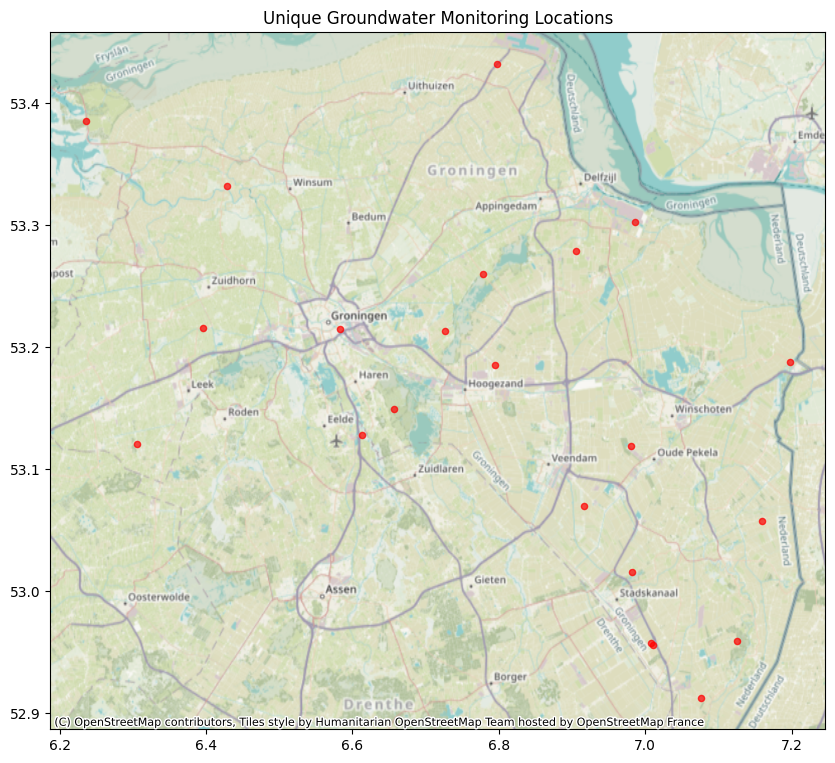

In [2]:
import pandas as pd
import geopandas as gpd

path = '/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/data/clean/well_chem_data/for_Alignment/groningen_well_chem_combined_1.csv'

df = pd.read_csv(path)  # or pass your DataFrame directly

# 2. Convert WKT geometry to shapely Point
df["geometry"] = df["geometry"].apply(wkt.loads)

# 3. Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")  # WGS84

# 4. Drop duplicates to get unique locations
gdf_unique = gdf.drop_duplicates(subset=["geometry"])

# 5. Plot
ax = gdf_unique.plot(figsize=(10, 10), color="red", markersize=20, alpha=0.7)

# Add a basemap (optional)
ctx.add_basemap(ax, crs=gdf.crs.to_string())

# Add labels or title
ax.set_title("Unique Groundwater Monitoring Locations")

plt.show()